In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import (Image)

### Q84：CMYK色空間

CMYKもnumpyやPillowで扱うことが可能である. 
CMYKは印刷でよく使われる色空間である. 

numpy配列は単純にHxWx4の次元にしておけばよい. データ型はnp.uint8

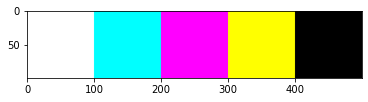

In [2]:
H, W = 100, 100
canvas = np.full((H, W * 5, 4), 0, dtype = np.uint8)

for i in range(4):
    o = (i + 1) * W
    canvas[:, o:(o + W), i] = 255

plt.imshow(Image.fromarray(canvas, "CMYK"))


### Q85：加法混色，減法混色

RGBはすべて255にすると白になるが，CMYKは黒になる. 


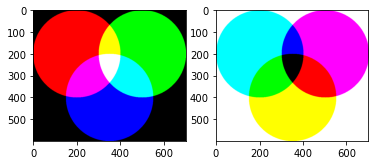

In [3]:
H, W = 600, 700
c_rgb  = np.full((H, W, 3), 255, dtype = np.uint8)
c_cmyk = np.full((H, W, 4), 255, dtype = np.uint8)

idy, idx  = np.indices((H, W))
m_circle1 = np.sqrt((idy - 200) ** 2 + (idx - 200) ** 2) <= 200
m_circle2 = np.sqrt((idy - 200) ** 2 + (idx - 500) ** 2) <= 200
m_circle3 = np.sqrt((idy - 400) ** 2 + (idx - 350) ** 2) <= 200

c_rgb [m_circle1, 0] = 0
c_cmyk[m_circle1, 0] = 0

c_rgb [m_circle2, 1] = 0
c_cmyk[m_circle2, 1] = 0

c_rgb [m_circle3, 2] = 0
c_cmyk[m_circle3, 2] = 0

# Kも255になっているのでマスクの部分は０にする
c_cmyk[m_circle1 +  m_circle2 +  m_circle3 > 0, 3] = 0


fig, axs = plt.subplots(1, 2)
axs[0].imshow(Image.fromarray(c_cmyk, "CMYK"))
axs[1].imshow(c_rgb)

### Q86：CMYKのグラデーション



In [4]:
x = np.zeros((256, 256, 4), dtype = np.uint8)
x[..., 0] = np.arange(256).astype(np.uint8)[:, None]
x[..., 1] = np.arange(256).astype(np.uint8)

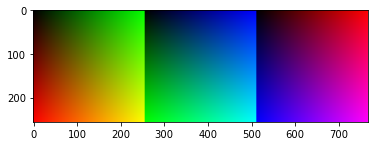

In [5]:
ret = []

for i in range(3):
    j  = (i + 1) % 3
    x = np.zeros((256, 256, 3), dtype = np.uint8)
    x[..., i] = np.arange(256).astype(np.uint8)[:, None]
    x[..., j] = np.arange(256).astype(np.uint8)
    ret.append(x)

plt.imshow(np.concatenate(ret, axis = 1))

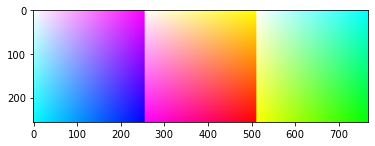

In [6]:
ret = []

for i in range(3):
    j  = (i + 1) % 3
    x = np.zeros((256, 256, 3), dtype = np.uint8)
    x[..., i] = np.arange(256).astype(np.uint8)[:, None]
    x[..., j] = np.arange(256).astype(np.uint8)
    # Kの部分を追加
    x = np.concatenate([x, np.zeros((256, 256, 1), dtype = np.uint8)], axis = 2)
    ret.append(np.array(Image.fromarray(x, "CMYK").convert("RGB")))

out = np.concatenate(ret, axis = 1)
plt.imshow(out)

### Q87：CMYKのくすみ

実際に印刷してみると，RGBから変換したCMYKはくすんだ印象を受ける. 



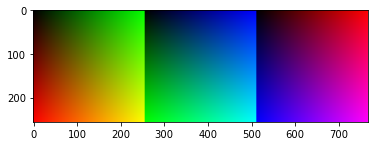

In [7]:
ret = []

for i in range(3):
    j  = (i + 1) % 3
    x = np.zeros((256, 256, 3), dtype = np.uint8)
    x[..., i] = np.arange(256).astype(np.uint8)[:, None]
    x[..., j] = np.arange(256).astype(np.uint8)
    ret.append(x)

out = np.concatenate(ret, axis = 1)
plt.imshow(out)

In [8]:
img = Image.fromarray(out)
img.save("out/rgb.jpg")

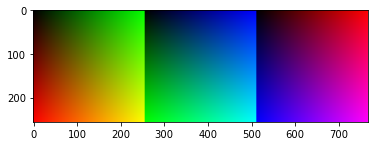

In [9]:
cymk = img.convert("CMYK")

# プロットは問題なくても
# ビューワーで見てみるとくすんでいる
cymk.save("out/cmyk.jpg")
plt.imshow(cymk)

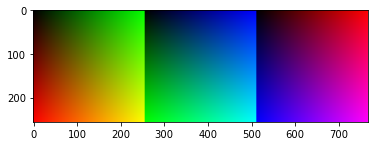

In [10]:
# もとのRGB
plt.imshow(cymk.convert("RGB"))

### Q88：カラープロファイルを埋め込んだ画像

カラープロファイルがあると，プロットでも，CMYKのくすみを再現できる. 

詳細ははぶくが，ADbeからダウンロードする. 

In [11]:
with open("dat/JapanColor2001Coated.icc", "rb") as fp:
    profile = fp.read()

img.save("out/filename.jpg",  icc_profile = profile)

In [12]:
cymk.save("out/cmyk_with_profile.jpg", icc_profile = profile)

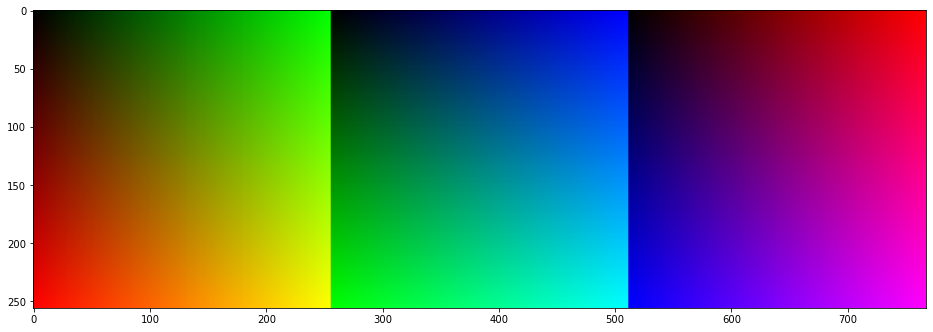

In [13]:
fig = plt.figure(figsize = (16, 16))
with Image.open("out/cmyk_with_profile.jpg") as img:
    plt.imshow(img)

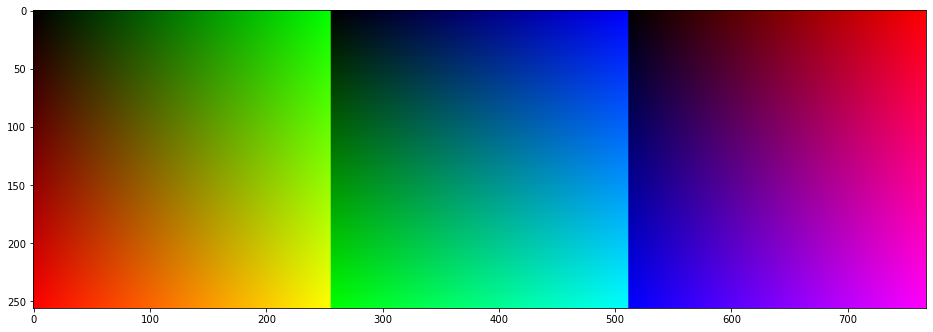

In [14]:
fig = plt.figure(figsize = (16, 16))
plt.imshow(out)

### Q92：スプライ補間と任意の曲線

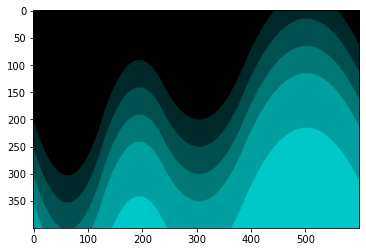

In [15]:
import scipy.interpolate

H, W = 400, 600
img = np.full((H, W, 3), 0, dtype = np.uint8)

points = np.array([
    [0,   300],
    [75,  399],
    [175, 200],
    [300, 300],
    [470,  75],
    [599, 165],
])

idy, idx = np.indices((H, W))
func  = scipy.interpolate.interp1d(points[:, 0], points[:, 1], kind = "quadratic")
y_new = func(idx)

for border in [-100, -50, 0, 50, 150]:
    mask = idy - y_new >= border
    img[mask, 1:3] += 40


plt.imshow(img)

### Q93：二次元の補間


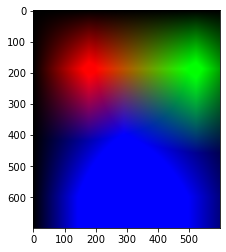

In [16]:
import scipy.interpolate

H, W = 600, 700
img = np.full((H, W, 3), 0, dtype = np.uint8)
idy, idx = np.indices((H, W))

points = np.array([
    [0,   300],
    [75,  399],
    [175, 200],
    [300, 300],
    [470,  75],
    [599, 165],
])

# X, Y, R, G, Bになっている
# R, G, Bごとに補間を実行すること
data = np.array([
    [0, 0, 0, 0, 0],
    [0, 599, 0, 0, 0], 
    [699, 0, 0, 0, 0], 
    [699, 599, 0, 0, 0], 
    [200, 200, 255, 0, 0], 
    [500, 200, 0, 255, 0],
    [300, 400, 0, 0, 255]
])

ret = []
for i in range(3):
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2+i]
    func  = scipy.interpolate.interp2d(x, y, z)
    # メッシュグリッドは関数内でやってくれる
    new_z = func(np.arange(H), np.arange(W))
    ret.append(new_z)

img = np.clip(np.stack(ret, axis = 2), 0, 255).astype(np.uint8)
plt.imshow(img)



### Q95：文字を入れる場所

画像に著作権表記などの文字を入れたい場合の処理. 

文字は目立つところ，つまり，輝度の差が大きいところに入れる方がよいとする. 



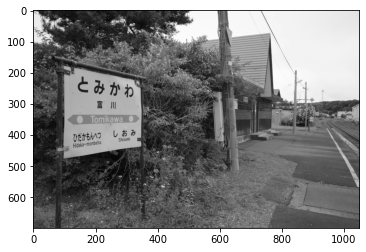

In [17]:
from PIL import Image, ImageDraw, ImageFont

with Image.open("numpy_book/imgs/pic01.jpg") as img:
    pic01   = np.array(img)
    pic01_l = np.array(img.convert("L"))
    H, W, _ = pic01.shape
    plt.imshow(pic01_l, cmap = "gray")


In [18]:
pic01_l.shape

(700, 1050)

In [19]:
batch_y, batch_x = 25, 200
oy, ox, orect_kido = 0, 0, 0
for ox_c in range(0, W-batch_x, batch_x):
    for oy_c in range(0, H-batch_y, batch_y):
        rect_kido = np.mean(pic01_l[oy_c:(oy_c+batch_y), ox_c:(ox_c+batch_x)])
        if orect_kido < rect_kido:
            orect_kido = rect_kido
            oy, ox = oy_c, ox_c
print(oy, ox)

125 800


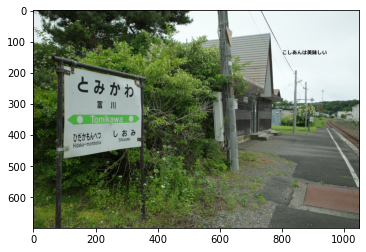

In [20]:
draw = ImageDraw.Draw(img)
font = ImageFont.truetype("numpy_book/fonts/M_PLUS_1p/MPLUS1p-Bold.ttf", 16)
draw.text((ox, oy), "こしあんは美味しい", font = font, fill = 0)
plt.imshow(img)

### Q96：なんかダサそうなロゴ

In [21]:
with Image.open("numpy_book/imgs/water.jpg") as img:
    water = np.array(img)

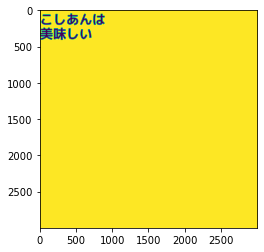

In [22]:
canvas = Image.fromarray(np.full((3000, 3000), 255, dtype = np.uint8))
draw = ImageDraw.Draw(canvas)
font = ImageFont.truetype("numpy_book/fonts/M_PLUS_1p/MPLUS1p-Bold.ttf", 180)
draw.text((0, 0), "こしあんは\n美味しい", font = font, fill = 0)
plt.imshow(canvas)

9 49 887 409


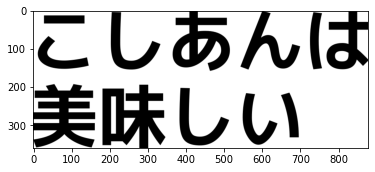

In [23]:
text_arr = np.array(canvas)
y_pos, x_pos = np.where(text_arr == 0)
lx, ly, ux, uy = np.min(x_pos), np.min(y_pos), np.max(x_pos), np.max(y_pos)
print(lx, ly, ux, uy)
text_arr = text_arr[ly:uy, lx:ux]
plt.imshow(text_arr, cmap = "gray")

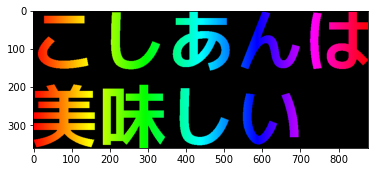

In [24]:
H_t, W_t = uy - ly, ux - lx
grad = np.full((H_t, W_t, 3), 255, dtype = np.uint8)
grad[..., 0] = np.linspace(0, 255, W_t)[None, :].astype(np.uint8)
mask = text_arr > 0
grad[mask, 2] = 0
plt.imshow(Image.fromarray(grad, "HSV"))

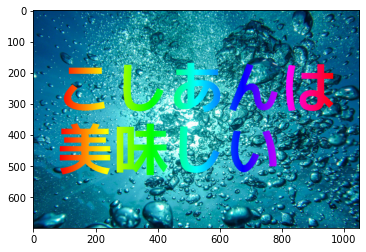

In [25]:
rainbow = np.array(Image.fromarray(grad, "HSV").convert("RGB"))

H_w, W_w, _ = water.shape
oy, ox = H_w // 2 - H_t // 2, W_w // 2 - W_t // 2
water[oy:oy + H_t, ox:ox + W_t, :] = \
     (mask[..., None]) * water[oy:oy + H_t, ox:ox + W_t, :] + \
     (1-mask[..., None]) * rainbow
plt.imshow(water)

In [26]:
# 行列のサイズが異なる場合には次のようなpad関数を使えとのこと
# 入力サイズを合わせるのに使えそうですね
a = [1, 2, 3, 4, 5]
np.pad(a, (2, 3), 'constant', constant_values=(4, 6))

array([4, 4, 1, 2, 3, 4, 5, 6, 6, 6])

### Q97：ブレンドヲ変えてみる. 

In [123]:
def vividlight(img1, img2):
    epsilon = 1e-8
    layer1  = 1 - (1 - img1) / (2 * img2 + epsilon)
    layer2  = img1 / (1 - 2 * (img2 - .5) + epsilon)
    mask = img2 < .5
    out  = mask * layer1 + (1-mask) * layer2
    out  = np.clip(out, 0, 1)
    return out

def overlay(i1, i2):
    layer_1 = 2 * i1 * i2
    layer_2 = 1 - 2 * (1- i1) * (1 -i2)
    mask    = i1 < .5
    out     = np.clip(mask * layer_1 + (1-mask) * layer_2, 0, 1)
    return out

In [190]:
with Image.open("numpy_book/imgs/water.jpg") as img:
    water = np.array(img) / 255.
    H_w, W_w, _ = water.shape

canvas = Image.fromarray(np.full((3000, 3000), 255, dtype = np.uint8))
draw = ImageDraw.Draw(canvas)
font = ImageFont.truetype("numpy_book/fonts/M_PLUS_1p/MPLUS1p-Bold.ttf", 180)
draw.text((0, 0), "こしあんは\n美味しい", font = font, fill = 0)
text_arr = np.array(canvas)
y_pos, x_pos = np.where(text_arr == 0)
lx, ly, ux, uy = np.min(x_pos), np.min(y_pos), np.max(x_pos), np.max(y_pos)
text_arr = text_arr[ly:uy, lx:ux]
H_t, W_t = text_arr.shape


grad = np.full((H_t, W_t, 3), 255, dtype = np.uint8)
grad[..., 0] = np.linspace(-50, 50, W_t)[None, :].astype(np.uint8)
grad[..., 1] = 160
grad = np.array(Image.fromarray(grad, "HSV").convert("RGB"))
m = text_arr == 0
grad = m[..., None] * grad
delta_h = (H_w - H_t) // 2
delta_w = (W_w - W_t) // 2
grad = np.pad(
    grad / 255.,
    # 軸後ごとに，前後にどれだけ足すのかを記述する 
    ((delta_h, delta_h), (delta_w, delta_w), (0, 0,)), 
    "constant", 
    constant_values = 0.
)

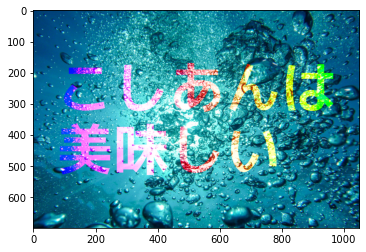

In [192]:
o = vividlight(water, grad)
o = overlay(o, o)
# 文字の部分やpadの部分は０になっている
m = np.all(grad != 0, axis = 2, keepdims = True)
v = m * o + (1-m) * water
plt.imshow(v)

In [186]:

o.shape

(700, 1050, 3)

In [187]:
water.shape

(700, 1050, 3)

### Q98:写真がないページの判定


In [193]:
dat = np.load("numpy_book/data/chap04_q98.npz")["pics"]
dat.shape

(9, 256, 256, 3)

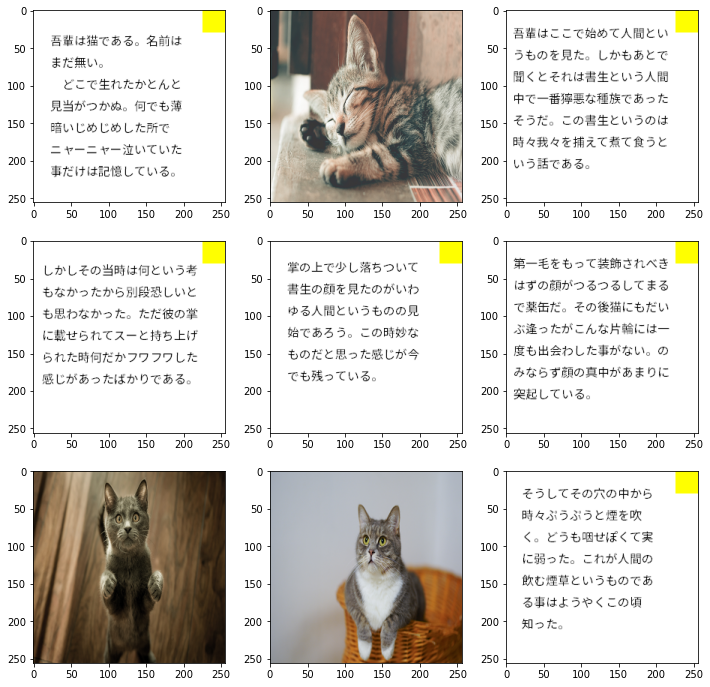

In [208]:
fig, axes = plt.subplots(3, 3, figsize = (12,12))
for i in np.arange(9):
    pic = dat[i]
    sub_area = pic[:30, -30:]
    is_white = np.all(sub_area == 255)
    if is_white:
        sub_area[...] = np.array([255, 255, 0], dtype = np.uint8)
    axes[i // 3][i % 3].imshow(pic)

### Q99：白黒画像の除外.

In [215]:
dat = np.load("numpy_book/data/chap04_q99.npz")["pics"]
dat.shape

(10, 256, 256, 3)

In [227]:
def is_wb(arr):
    hsv = np.array(Image.fromarray(arr).convert("HSV"))
    return np.all(hsv[..., 1] == 0)

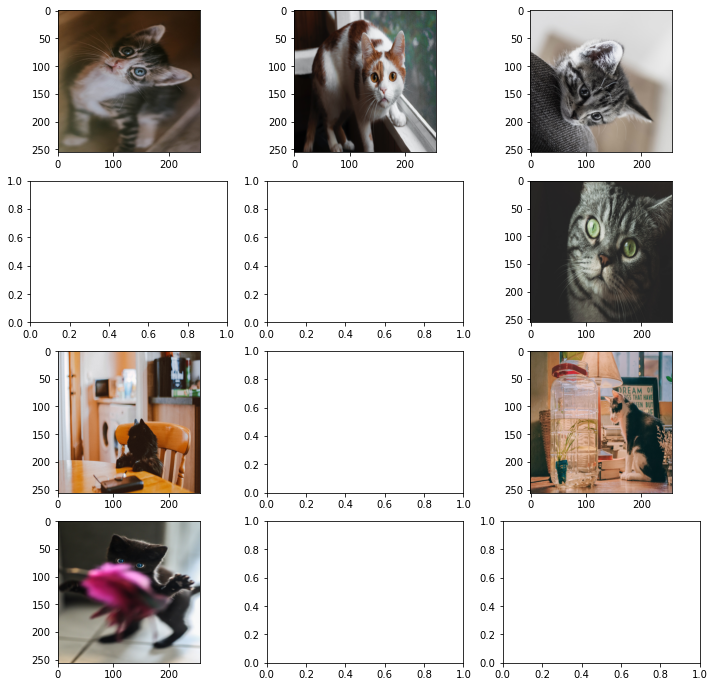

In [229]:
fig, axes = plt.subplots(4, 3, figsize = (12,12))
for i in np.arange(10):
    pic = dat[i]
    if not is_wb(pic):
        axes[i // 3][i % 3].imshow(pic)


### Q100：モザイク

モザイクをかけるには低解像度にしてもとの写真に戻すということをすれば良い. 

Pillowは(x, y)の順番であることに注意すること. 



In [280]:
with Image.open("numpy_book/imgs/girl01.png") as img:
    girl = np.array(img)
    girl_resized = img.resize((img.width // 15, img.height // 15), Image.NEAREST)\
        .resize((img.width, img.height), Image.NEAREST)
    girl[10:300, 150:500] = np.array(girl_resized)[10:300, 150:500]


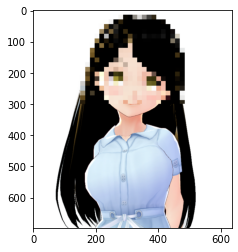

In [281]:
plt.imshow(girl)